In [2]:
# Importing the required libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing import image
from PIL import Image

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp '/content/kaggle.json' ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [6]:
!kaggle datasets download -d sakashgundale/grapes-images

 85% 129M/151M [00:01<00:00, 132MB/s]
100% 151M/151M [00:01<00:00, 140MB/s]


In [7]:
!unzip -qq '/content/grapes-images.zip' -d '/content/dataset'

In [8]:
train_path = '/content/dataset/grapes images/train'
val_path = '/content/dataset/grapes images/validation'

In [9]:
image_generator = ImageDataGenerator(rescale=1./255)
train_set = image_generator.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 7222 images belonging to 4 classes.


In [10]:
val_set = image_generator.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 1805 images belonging to 4 classes.


In [11]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))


58889256/58889256 [==============================] - 0s 0us/step


In [12]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [13]:
# Build the final model
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(train_set.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)


In [14]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [15]:
# Train the model
history = model.fit(
    train_set,
    steps_per_epoch=train_set.samples // train_set.batch_size,
    epochs=10,
    validation_data=val_set,
    validation_steps=val_set.samples // val_set.batch_size
)


Epoch 1/10
225/225 [==============================] - 78s 291ms/step - loss: 0.3295 - accuracy: 0.9072 - val_loss: 0.0827 - val_accuracy: 0.9704
Epoch 2/10
225/225 [==============================] - 73s 326ms/step - loss: 0.0634 - accuracy: 0.9776 - val_loss: 0.0694 - val_accuracy: 0.9665
Epoch 3/10
225/225 [==============================] - 70s 313ms/step - loss: 0.0396 - accuracy: 0.9862 - val_loss: 0.0523 - val_accuracy: 0.9805
Epoch 4/10
225/225 [==============================] - 70s 311ms/step - loss: 0.0133 - accuracy: 0.9975 - val_loss: 0.1060 - val_accuracy: 0.9621
Epoch 5/10
225/225 [==============================] - 71s 315ms/step - loss: 0.0074 - accuracy: 0.9994 - val_loss: 0.0319 - val_accuracy: 0.9900
Epoch 6/10
225/225 [==============================] - 43s 192ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0331 - val_accuracy: 0.9900
Epoch 7/10
225/225 [==============================] - 43s 192ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0347 - val_ac

In [17]:
import matplotlib.pyplot as plt

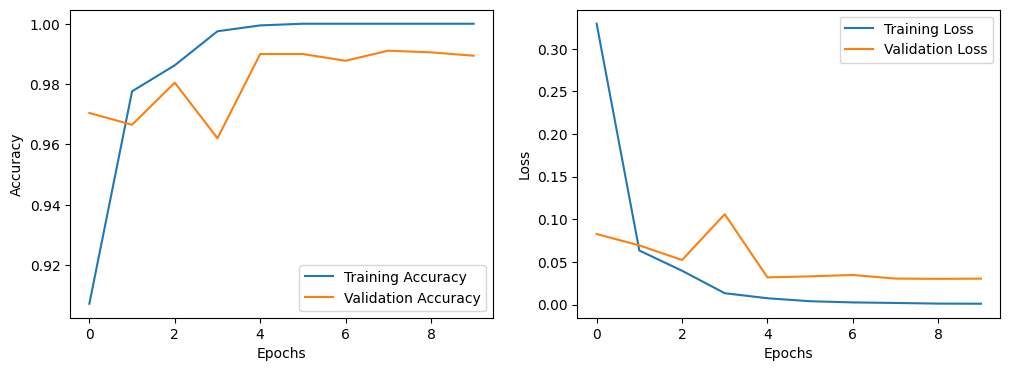

In [18]:
# Plot the accuracy and loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
# Make predictions on the validation set
predictions = model.predict(val_set)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = val_set.classes
class_labels = list(val_set.class_indices.keys())

57/57 [==============================] - 12s 216ms/step


In [20]:
# Generate the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print('Classification Report:')
print(report)

Classification Report:
                                            precision    recall  f1-score   support

                         Grape___Black_rot       0.99      0.97      0.98       472
              Grape___Esca_(Black_Measles)       0.98      0.99      0.98       480
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)       1.00      1.00      1.00       430
                           Grape___healthy       1.00      1.00      1.00       423

                                  accuracy                           0.99      1805
                                 macro avg       0.99      0.99      0.99      1805
                              weighted avg       0.99      0.99      0.99      1805



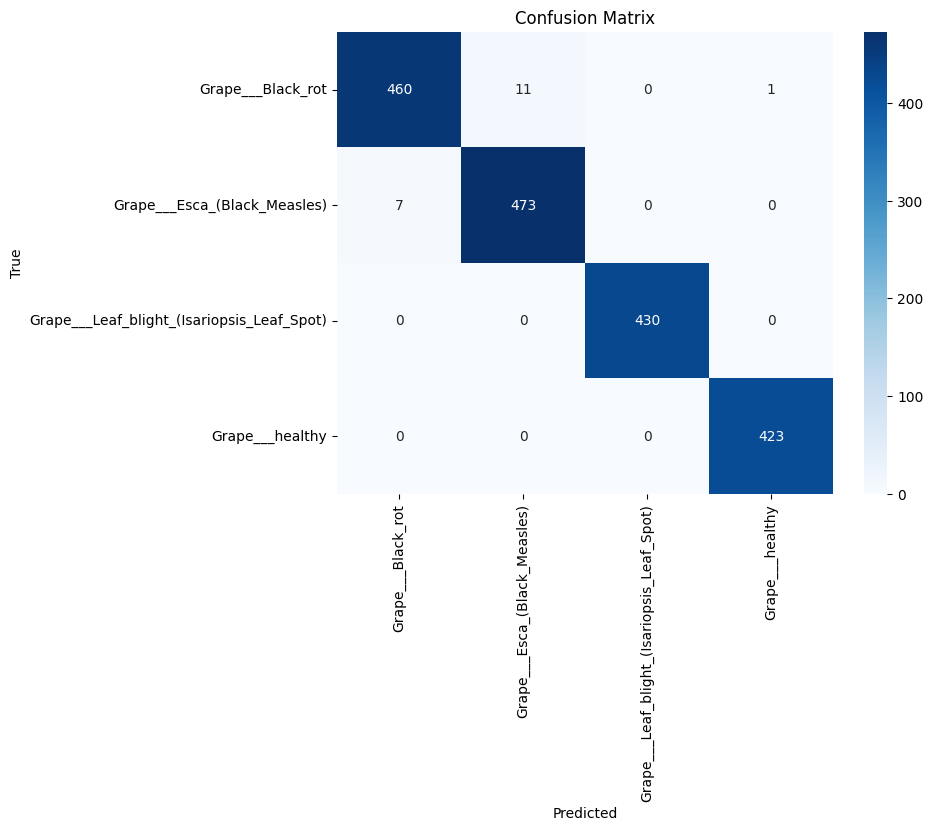

In [21]:
# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [34]:
image_path = '/content/dataset/grapes images/train/Grape___Leaf_blight_(Isariopsis_Leaf_Spot)/002e4d32-15cf-4350-bfba-dde7c8992392___FAM_L.Blight 4740.JPG'


In [35]:
# Load and preprocess the image
img = Image.open(image_path)
img = img.resize((224, 224))
img_array = np.array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

In [36]:
# Make predictions using the trained model
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])
predicted_class = class_labels[predicted_class_index]

1/1 [==============================] - 0s 202ms/step


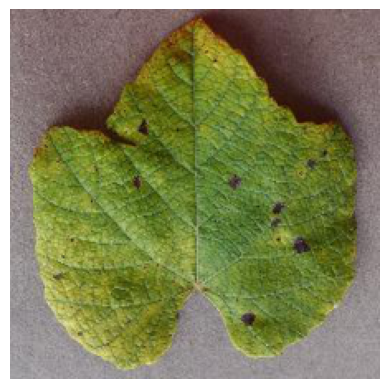

In [37]:
# Display the uploaded image
plt.imshow(img)
plt.axis('off')
plt.show()

In [38]:
# Print the predicted class
print('Image: grape_leaf.jpeg')
print('Predicted Class:', predicted_class)

Image: grape_leaf.jpeg
Predicted Class: Grape___Leaf_blight_(Isariopsis_Leaf_Spot)


In [39]:
# Save the model weights
model.save_weights('/content/drive/MyDrive/model_weights.h5')
print('Model weights saved.')


Model weights saved.


In [40]:
# Load the saved model weights
model.load_weights('/content/drive/MyDrive/model_weights.h5')
print('Model weights loaded.')


Model weights loaded.


In [41]:
# Image preprocessing using ImageDataGenerator with augmentation
image_generator = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20
)
train_set = image_generator.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 7222 images belonging to 4 classes.


In [43]:
# Evaluate the model on the test set
test_path = '/content/dataset/grapes images/validation'
test_set = image_generator.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
test_loss, test_accuracy = model.evaluate(test_set)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)


Found 1805 images belonging to 4 classes.
57/57 [==============================] - 30s 519ms/step - loss: 0.1171 - accuracy: 0.9645
Test Loss: 0.11710601300001144
Test Accuracy: 0.9645429253578186
